In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#### Функции для бэктеста

In [2]:
def data_reader(name):
    return pd.read_csv(name, index_col='Unnamed: 0')

def returns_calculator(close):
    return (close / close.shift(axis=1) - 1).dropna(axis=1)

def neutralization(alpha):
    return alpha - alpha.mean()

def normalization(alpha):
    return alpha / alpha.abs().sum()

def profit(alpha, returns):
    return (alpha.shift(axis=1) * returns).dropna(axis=1).sum()

def cumprofit(profit):
    return profit.cumsum()

def turnover(alpha):
    return (alpha.shift(axis=1) - alpha).dropna(axis=1).abs().sum()

def sharpe(profit):
    return np.sqrt(len(profit)) * profit.mean() / profit.std()

def drawdorn(cumprofit):
    drawDown = 0
    maxValue = cumprofit[0]
    for i in cumprofit:
        if i > maxValue:
            maxValue = i
        else:
            if maxValue - i > drawDown:
                drawDown = maxValue - i
    return drawDown

def truncate(alpha, threshold):
    alpha[alpha > threshold] = threshold
    alpha[alpha < -threshold] = -threshold
    alpha[alpha >= 0] /= (2 * np.sum(alpha[alpha >= 0]))
    alpha[alpha < 0] /= (2 * np.sum(alpha[alpha < 0]))
    return alpha

def CutOutliers(alpha, number):
    if number % 2 == 0:
        return alpha.where(
            alpha >= alpha.sort_values()[number // 2 - 1],
            0
            ).where(
                alpha <= alpha.sort_values()[-(number // 2)],
                0
            )

    else:
        return alpha.where(
            alpha >= alpha.sort_values()[number // 2],
            0
            ).where(
                alpha <= alpha.sort_values()[-(number // 2)],
                0
            )

def CutMiddle(alpha, number):
    if number % 2 == 0:
        return alpha.mask(
                (alpha >= alpha.sort_values()[len(alpha) // 2 - number // 2]) & (alpha <= alpha.sort_values()[len(alpha) // 2 + number // 2]),
                0
            )

    else:
        return alpha.mask(
                (alpha >= alpha.sort_values()[len(alpha) // 2 - number // 2 + 1]) & (alpha <= alpha.sort_values()[len(alpha) // 2 + number // 2]),
                0
            )

def truncate(alpha, threshold):
    return alpha.where(
            alpha <= threshold,
            threshold
        ).where(
            alpha >= -threshold,
            -threshold
        )

def rank(vector):
    a = list(enumerate(vector))
    a.sort(key=lambda x: x[1])

    for i in range(len(a)):
        a[i] = list(a[i])

    for i in range(len(a)):
        a[i].append((i + 1) / len(a))

    a.sort(key=lambda x: x[0])
    b = [i[2] for i in a]

    return b

def decay(alpha, n):
    s = []

    for i in range(n):
        s.append(i)

    s = np.array(rank(s))

    d_alpha = pd.DataFrame(alpha[alpha.columns[n - 1:]])
    for i in range(len(alpha.columns) - n):
        d_alpha[alpha.columns[i + n - 1]] = np.sum(pd.DataFrame(alpha[alpha.columns[i: n + i]]) * s, axis=1)

    for i in range(len(d_alpha.columns)):
        d_alpha[d_alpha.columns[i]] = normalization(neutralization(d_alpha[d_alpha.columns[i]]))

    return d_alpha

def sharpe_per_year(alpha, profits):
    s = set()
    dates = []

    for i in profits.index:
        s.add(i[:4])
    s = list(s)
    s.sort()

    for i in s:
        dates.append([])

    for i in range(len(s)):
        for j in profits.index:
            if j[:4] == s[i]:
                dates[i].append(j)

    year_sharpes = []
    for i in dates:
        year_sharpes.append(sharpe(profits[i]))

    return year_sharpes

def matrix(alpha: list) -> pd.DataFrame:
    pnl = pd.DataFrame()
    pnl_sum = []
    mean_turnover = []
    good_sharp_years = []
    index = []
    for i in range(len(alpha)):
        pnl['alpha' + str(i + 1)] = alpha[i][1]
        pnl_sum.append(
            np.sum(
                alpha[i][1]
            )
        )
        mean_turnover.append(
            np.mean(
                turnover(alpha[i][0])
            )
        )
        good_sharp_years.append(
            np.sum(
                np.array(sharpe_per_year(alpha[i][0], alpha[i][1])) > 1
            )
        )
        corr_matrix = pnl.dropna().corr()
        index.append('alpha' + str(i + 1))
    return pd.concat(
            [
                pd.DataFrame(
                    {
                    'pnl': pnl_sum,
                    'mean_turnover': mean_turnover,
                    'good_sharp_years': good_sharp_years
                    },
                    index=index
                ),
                corr_matrix
            ],
            axis=1
        )

#### Функции для поиска альф

In [3]:
def alpha_one_delta(data, delta):
    return (
            (
                -data / data.shift(delta, axis=1) + 1
            )
            .dropna(axis=1)
            .apply(neutralization)
            .apply(normalization)
            .shift(1, axis=1)
            .dropna(axis=1)
        )

def alpha_high_low_close(high, low, close):
    return (
        (
            (high - low) / close
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_high_low(high, low):
    return (
        (
            high / low
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_high_low_2close_close(high, low, close):
    return (
        (
            (high + low - 2 * close) / close
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_high_low_close2(high, low, close):
    return (
        (
            high * low / close ** 2
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_open_close(open, close):
    return (
        (
            open / close
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_high_close(high, close):
    return (
        (
            high / close
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_close_low_high(close, low, high):
    return (
        (
            -(close - low) / (high - low)
        )
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1).drop('2010-01-04', axis=1)
    )

def alpha_if_high_low_close(high, low, close):
    return (
        ((high + low) / 2 < close).replace([False, True], [1, -1])
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
    )

def alpha_if_close_low_high(close, low, high):
    return (
        (
            ((close - low) / (high - low) < 0.5).replace([False, True], [-1, 1])
        )
        .dropna(axis=1)
        .apply(neutralization)
        .apply(normalization)
        .shift(1, axis=1)
        .dropna(axis=1)
    )

def alpha_SMB(close, delta, n):
    alpha = pd.DataFrame()
    profit = pd.DataFrame()

    num = int(len(close) / n)

    for i in range(len(close.columns) - 1):
        profit[close.columns[i + 1]] = close[close.columns[i + 1]] / close[close.columns[i]] - 1
    profit.index = close.index

    for i in range(len(profit.columns) - delta):
        alpha[profit.columns[i + delta]] = np.where(
            profit[profit.columns[i]] <= profit[profit.columns[i]].sort_values()[num],
            0.4 / (num + 1),
            np.where(
                profit[profit.columns[i]] >= profit[profit.columns[i]].sort_values()[len(profit[profit.columns]) - num],
                -0.4 / (num + 1),
                0
                )
            )
    alpha.index = close.index

    return alpha.apply(neutralization).apply(normalization)

In [4]:
close = data_reader('data/Close.csv')
open = data_reader('data/Open.csv')
high = data_reader('data/High.csv')
low = data_reader('data/Low.csv')
volume = data_reader('data/sVolume.csv')

returns = returns_calculator(close)

In [5]:
alphas = []

#### $$alpha = close(d)/close(d-3) - 1$$

In [6]:
alpha = decay(
    alpha_one_delta(close, 3).apply(lambda x: CutMiddle(x, 100)).apply(lambda x: CutOutliers(x, 12)).apply(lambda x: truncate(x, 0.003)),
    2
)
profits = profit(alpha, returns)

alphas.append([alpha, profits])

#### $$alpha = close(d)/close(d-15) - 1$$

In [7]:
alpha = alpha_one_delta(close, 15).apply(lambda x: CutMiddle(x, 1800)).apply(neutralization).apply(normalization)
profits = profit(alpha, returns)
alphas.append([alpha, profits])

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2
alpha1,0.460509,0.687797,3,1.00000,0.48713
alpha2,0.455983,0.433994,3,0.48713,1.00000


#### $$alpha = high / close$$

In [8]:
alpha = decay(alpha_high_close(high, close).apply(lambda x: CutMiddle(x, 100)), 6).apply(neutralization).apply(normalization)
profits = profit(alpha, returns)

alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(
    alphas
)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3
alpha1,0.460509,0.687797,3,1.000000,0.487130,0.391163
alpha2,0.455983,0.433994,3,0.487130,1.000000,0.280572
alpha3,0.502553,0.351423,4,0.391163,0.280572,1.000000


#### $$alpha = (high + low - 2close) / close$$

In [9]:
alpha = decay(
    alpha_high_low_2close_close(high, low, close).apply(lambda x: CutOutliers(x, 120)).apply(lambda x: CutMiddle(x, 2150)),
    4
)
profits = profit(alpha, returns)


alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4
alpha1,0.460509,0.687797,3,1.000000,0.487130,0.391163,0.478430
alpha2,0.455983,0.433994,3,0.487130,1.000000,0.280572,0.304138
alpha3,0.502553,0.351423,4,0.391163,0.280572,1.000000,0.251808
alpha4,0.491478,0.781209,5,0.478430,0.304138,0.251808,1.000000


#### $$alpha = open/close$$

In [10]:
alpha = decay(
    alpha_open_close(open, close).apply(lambda x: CutOutliers(x, 120)).apply(lambda x: CutMiddle(x, 2050)),
    6
)
profits = profit(alpha, returns)


alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4,alpha5
alpha1,0.460509,0.687797,3,1.000000,0.487130,0.391163,0.478430,0.492090
alpha2,0.455983,0.433994,3,0.487130,1.000000,0.280572,0.304138,0.332616
alpha3,0.502553,0.351423,4,0.391163,0.280572,1.000000,0.251808,0.405630
alpha4,0.491478,0.781209,5,0.478430,0.304138,0.251808,1.000000,0.061434
alpha5,0.412245,0.604046,4,0.492090,0.332616,0.405630,0.061434,1.000000


#### $$alpha = SMB-modified$$

In [11]:
alpha = decay(
    alpha_SMB(close, 2, 190),
    21
)
profits = profit(alpha, returns)

alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6
alpha1,0.460509,0.687797,3,1.000000,0.488035,0.390978,0.476229,0.489623,0.297804
alpha2,0.455983,0.433994,3,0.488035,1.000000,0.276752,0.303523,0.330772,0.484961
alpha3,0.502553,0.351423,4,0.390978,0.276752,1.000000,0.249773,0.403182,0.349773
alpha4,0.491478,0.781209,5,0.476229,0.303523,0.249773,1.000000,0.056837,0.075761
alpha5,0.412245,0.604046,4,0.489623,0.330772,0.403182,0.056837,1.000000,0.250254
alpha6,0.394409,0.201681,3,0.297804,0.484961,0.349773,0.075761,0.250254,1.000000


#### $$alpha=rank(-high(d))/rank(volume(d-11))$$

In [12]:
alpha = (-high.rank(pct=True).shift(11, axis=1) / volume.rank(pct=True)).apply(neutralization).apply(normalization)
profits = profit(alpha, returns)

alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7
alpha1,0.460509,0.687797,3,1.000000,0.488035,0.390978,0.476229,0.489623,0.297804,-0.122690
alpha2,0.455983,0.433994,3,0.488035,1.000000,0.276752,0.303523,0.330772,0.484961,-0.095184
alpha3,0.502553,0.351423,4,0.390978,0.276752,1.000000,0.249773,0.403182,0.349773,-0.202688
alpha4,0.491478,0.781209,5,0.476229,0.303523,0.249773,1.000000,0.056837,0.075761,-0.047119
alpha5,0.412245,0.604046,4,0.489623,0.330772,0.403182,0.056837,1.000000,0.250254,-0.084818
alpha6,0.394409,0.201681,3,0.297804,0.484961,0.349773,0.075761,0.250254,1.000000,-0.062912
alpha7,0.611986,0.250722,3,-0.122690,-0.095184,-0.202688,-0.047119,-0.084818,-0.062912,1.000000


#### $$alpha=(close-mean_{ewm}(close))/close$$

In [13]:
w = (close - close.ewm(35, axis=1).mean()) / close
w = (
        (w - w.mean())
        .shift(35, axis=1)
        .apply(lambda x: CutMiddle(x, 2022))
        .apply(lambda x: CutOutliers(x, 93))
        .apply(lambda x: truncate(x, 0.008))
        .apply(neutralization)
        .apply(normalization)
)
profits = profit(w, returns)

alphas.append(
    [
        w,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8
alpha1,0.460509,0.687797,3,1.000000,0.488301,0.392279,0.475442,0.488166,0.299021,-0.123933,-0.262447
alpha2,0.455983,0.433994,3,0.488301,1.000000,0.275920,0.303095,0.330387,0.485188,-0.096190,-0.051057
alpha3,0.502553,0.351423,4,0.392279,0.275920,1.000000,0.249743,0.404198,0.349890,-0.202501,-0.310245
alpha4,0.491478,0.781209,5,0.475442,0.303095,0.249743,1.000000,0.055202,0.075895,-0.046892,-0.027318
alpha5,0.412245,0.604046,4,0.488166,0.330387,0.404198,0.055202,1.000000,0.251198,-0.085397,0.211142
alpha6,0.394409,0.201681,3,0.299021,0.485188,0.349890,0.075895,0.251198,1.000000,-0.062897,-0.051872
alpha7,0.611986,0.250722,3,-0.123933,-0.096190,-0.202501,-0.046892,-0.085397,-0.062897,1.000000,0.152020
alpha8,0.543100,0.457621,3,-0.262447,-0.051057,-0.310245,-0.027318,0.211142,-0.051872,0.152020,1.000000


#### $$alpha=-(std_{ewm}(close-open) - std_{rolling}(close ^ 2 / high ^ 2))$$

In [14]:
alpha = (
        -((close - open).ewm(7, axis=1).std() - (close ** 2 / high ** 2).rolling(7, axis=1).std())
        .shift(8, axis=1)
        .dropna(axis=1)
        .apply(lambda x: truncate(x, 0.005))
        .apply(neutralization)
        .apply(normalization)
        .apply(lambda x: truncate(x, 0.0001))
        .apply(neutralization)
        .apply(normalization)
)
profits = profit(alpha, returns)

alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9
alpha1,0.460509,0.687797,3,1.000000,0.488301,0.392279,0.475442,0.488166,0.299021,-0.123933,-0.262447,-0.154835
alpha2,0.455983,0.433994,3,0.488301,1.000000,0.275920,0.303095,0.330387,0.485188,-0.096190,-0.051057,-0.357169
alpha3,0.502553,0.351423,4,0.392279,0.275920,1.000000,0.249743,0.404198,0.349890,-0.202501,-0.310245,0.186673
alpha4,0.491478,0.781209,5,0.475442,0.303095,0.249743,1.000000,0.055202,0.075895,-0.046892,-0.027318,-0.129574
alpha5,0.412245,0.604046,4,0.488166,0.330387,0.404198,0.055202,1.000000,0.251198,-0.085397,0.211142,0.155906
alpha6,0.394409,0.201681,3,0.299021,0.485188,0.349890,0.075895,0.251198,1.000000,-0.062897,-0.051872,-0.043531
alpha7,0.611986,0.250722,3,-0.123933,-0.096190,-0.202501,-0.046892,-0.085397,-0.062897,1.000000,0.152020,-0.009100
alpha8,0.543100,0.457621,3,-0.262447,-0.051057,-0.310245,-0.027318,0.211142,-0.051872,0.152020,1.000000,-0.040489
alpha9,1.868328,0.188102,5,-0.154835,-0.357169,0.186673,-0.129574,0.155906,-0.043531,-0.009100,-0.040489,1.000000


#### $$alpha=_{ewm}((high^3+low^3)/(open^3*low^2)/volume)^2$$

In [15]:
alpha = (
    (((high ** 3 + low ** 3) / (open ** 3 * low ** 2) / volume) ** 2)
    .ewm(5, axis=1)
    .mean()
    .shift(6, axis=1)
    .dropna(axis=1)
    .apply(lambda x: CutOutliers(x, 6))
    .apply(neutralization)
    .apply(normalization)
)
profits = profit(alpha, returns)

alphas.append(
    [
        alpha,
        profits
    ]
)

matrix(alphas)

,pnl,mean_turnover,good_sharp_years,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10
alpha1,0.460509,0.687797,3,1.000000,0.488301,0.392279,0.475442,0.488166,0.299021,-0.123933,-0.262447,-0.154835,-0.044800
alpha2,0.455983,0.433994,3,0.488301,1.000000,0.275920,0.303095,0.330387,0.485188,-0.096190,-0.051057,-0.357169,-0.058867
alpha3,0.502553,0.351423,4,0.392279,0.275920,1.000000,0.249743,0.404198,0.349890,-0.202501,-0.310245,0.186673,0.017643
alpha4,0.491478,0.781209,5,0.475442,0.303095,0.249743,1.000000,0.055202,0.075895,-0.046892,-0.027318,-0.129574,0.004648
alpha5,0.412245,0.604046,4,0.488166,0.330387,0.404198,0.055202,1.000000,0.251198,-0.085397,0.211142,0.155906,-0.104033
alpha6,0.394409,0.201681,3,0.299021,0.485188,0.349890,0.075895,0.251198,1.000000,-0.062897,-0.051872,-0.043531,0.013874
alpha7,0.611986,0.250722,3,-0.123933,-0.096190,-0.202501,-0.046892,-0.085397,-0.062897,1.000000,0.152020,-0.009100,-0.045614
alpha8,0.543100,0.457621,3,-0.262447,-0.051057,-0.310245,-0.027318,0.211142,-0.051872,0.152020,1.000000,-0.040489,-0.077466
alpha9,1.868328,0.188102,5,-0.154835,-0.357169,0.186673,-0.129574,0.155906,-0.043531,-0.009100,-0.040489,1.000000,0.105799
alpha10,1.117128,0.126568,3,-0.044800,-0.058867,0.017643,0.004648,-0.104033,0.013874,-0.045614,-0.077466,0.105799,1.000000


1252 1252.0 -8.40473524110763e-16
1241 1241.0 -3.365363543395006e-16
1251 1251.0 -4.2240516640035253e-16
1253 1253.0 8.751679936302992e-16
1251 1251.0 1.2231968909981461e-15
1234 1234.0 1.222312182025398e-13
1246 1246.0 -2.2551405187698492e-17
1257 1221.0 1.2967057982926633e-16
1243 1243.0 6.449386164009141e-12
1251 1251.0 -1.5959455978986625e-16


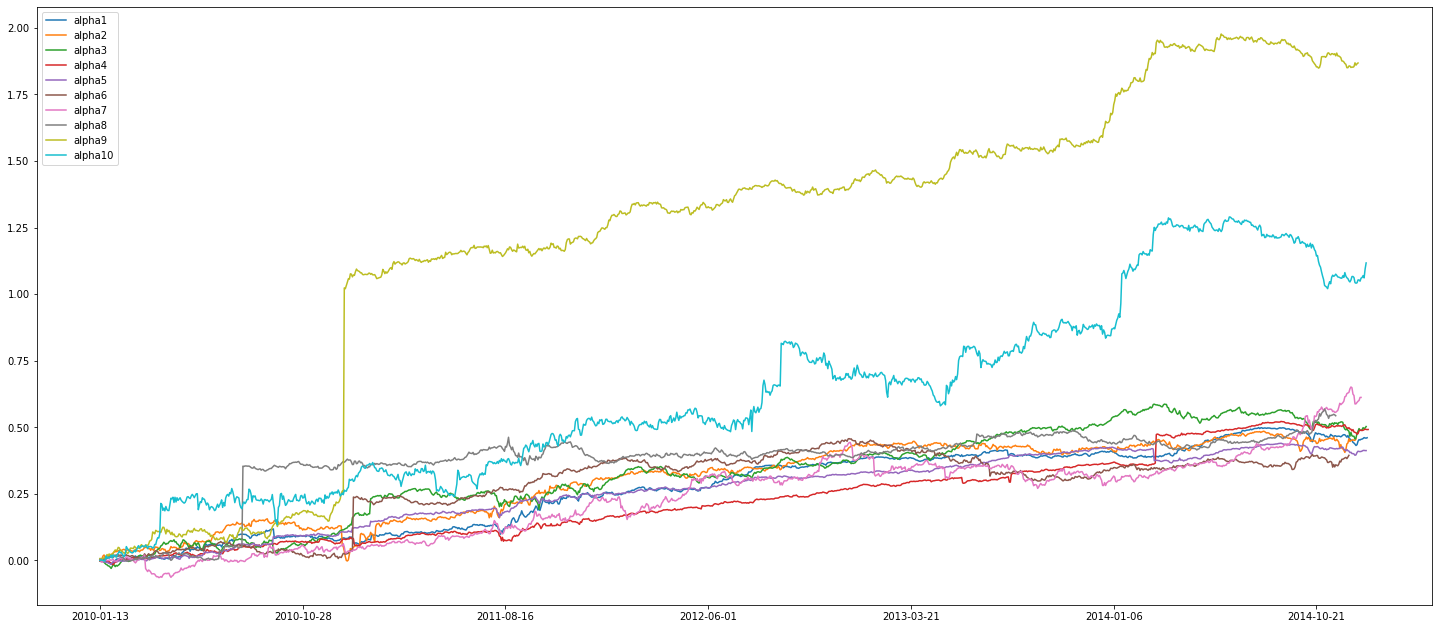

In [36]:
for i in alphas:
    print(len(i[0].columns), i[0].abs().sum().sum(), i[0].sum().sum())
    cumprofit(i[1]).plot(figsize=(25,11))
plt.legend(
    [
        'alpha1',
        'alpha2',
        'alpha3',
        'alpha4',
        'alpha5',
        'alpha6',
        'alpha7',
        'alpha8',
        'alpha9',
        'alpha10'
    ]
)
plt.show()

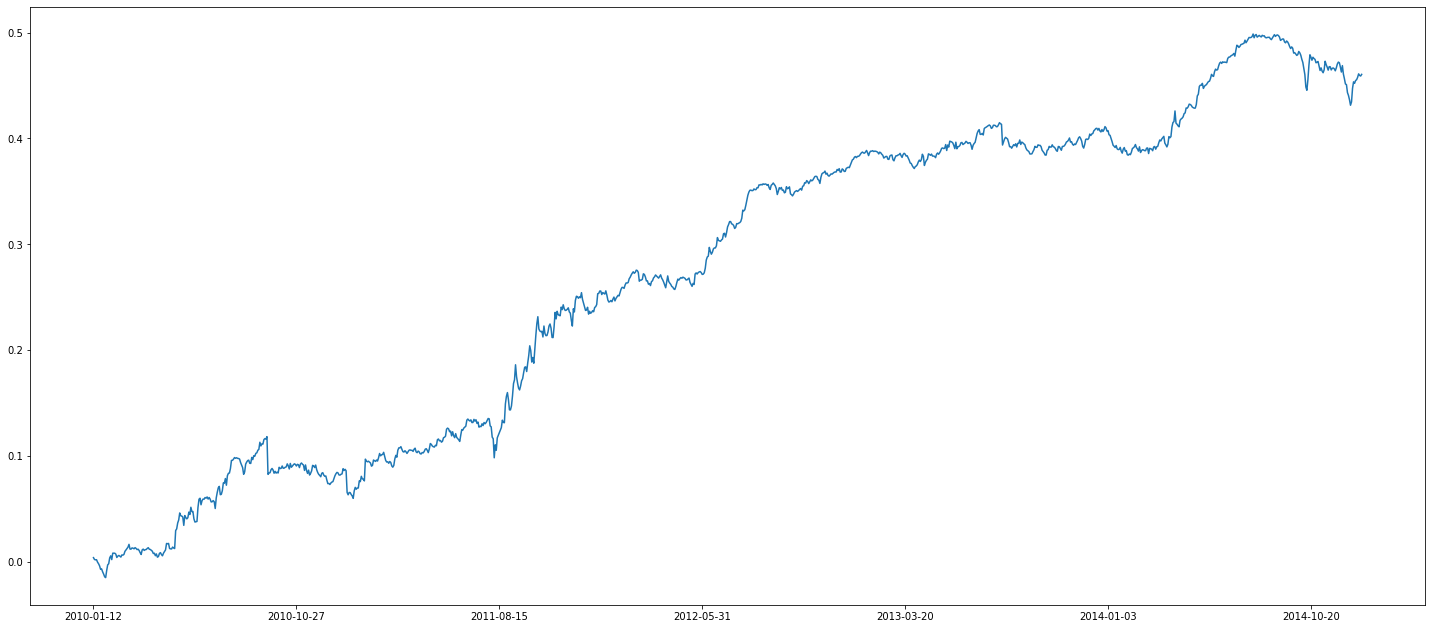

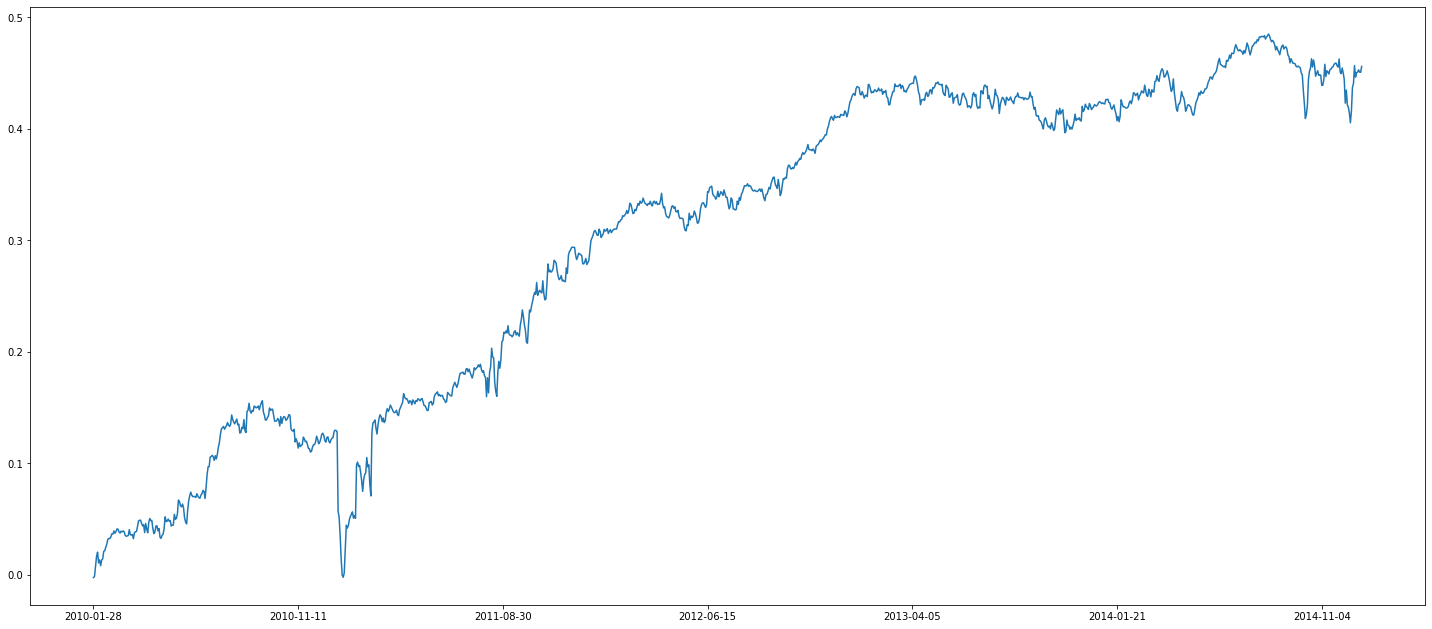

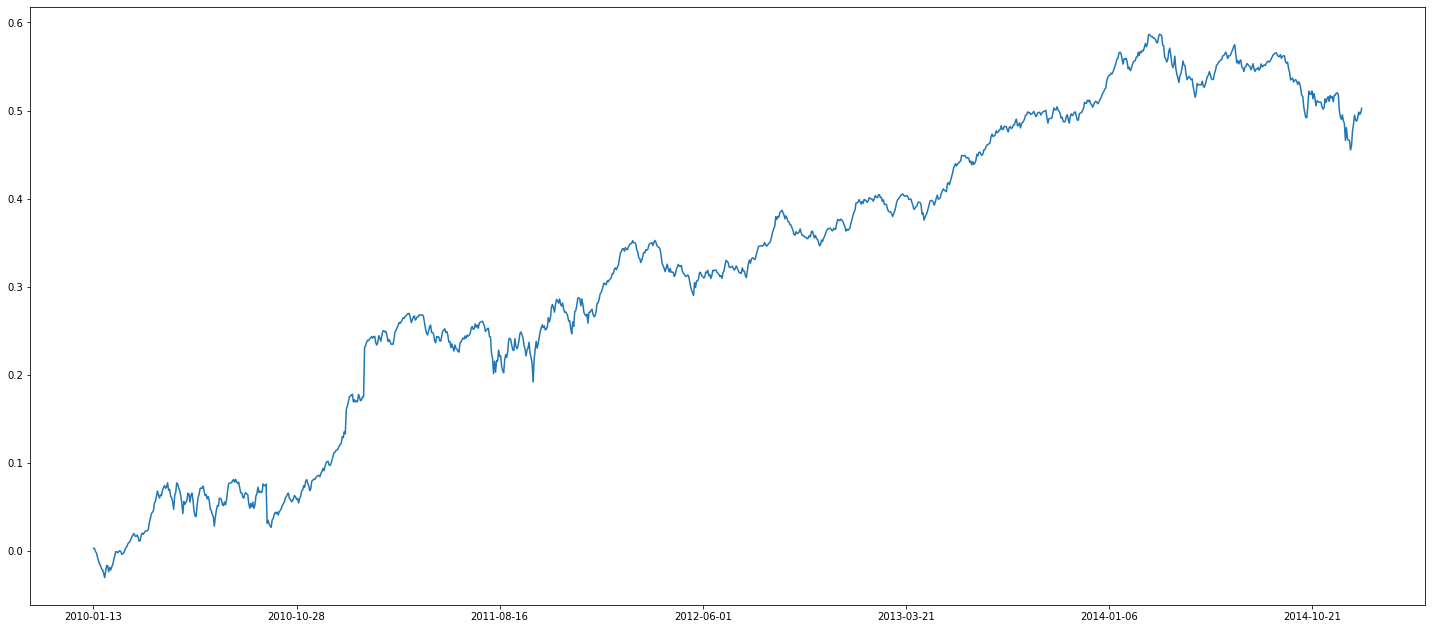

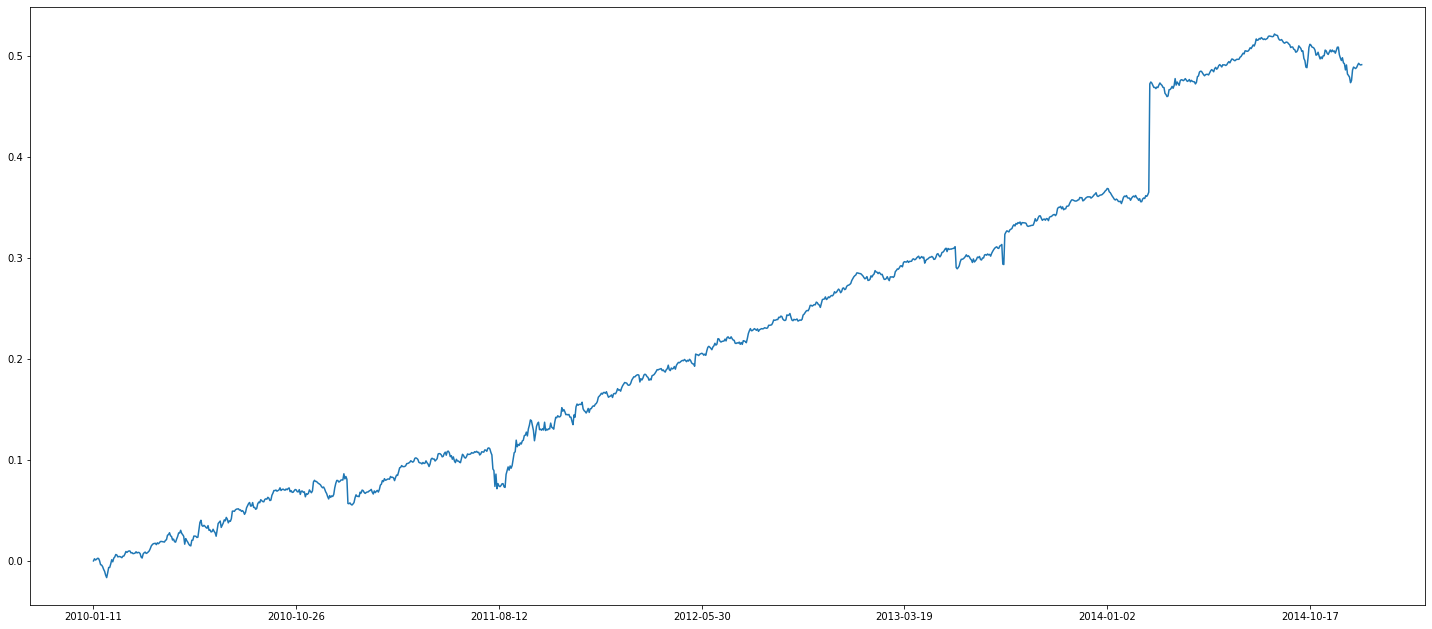

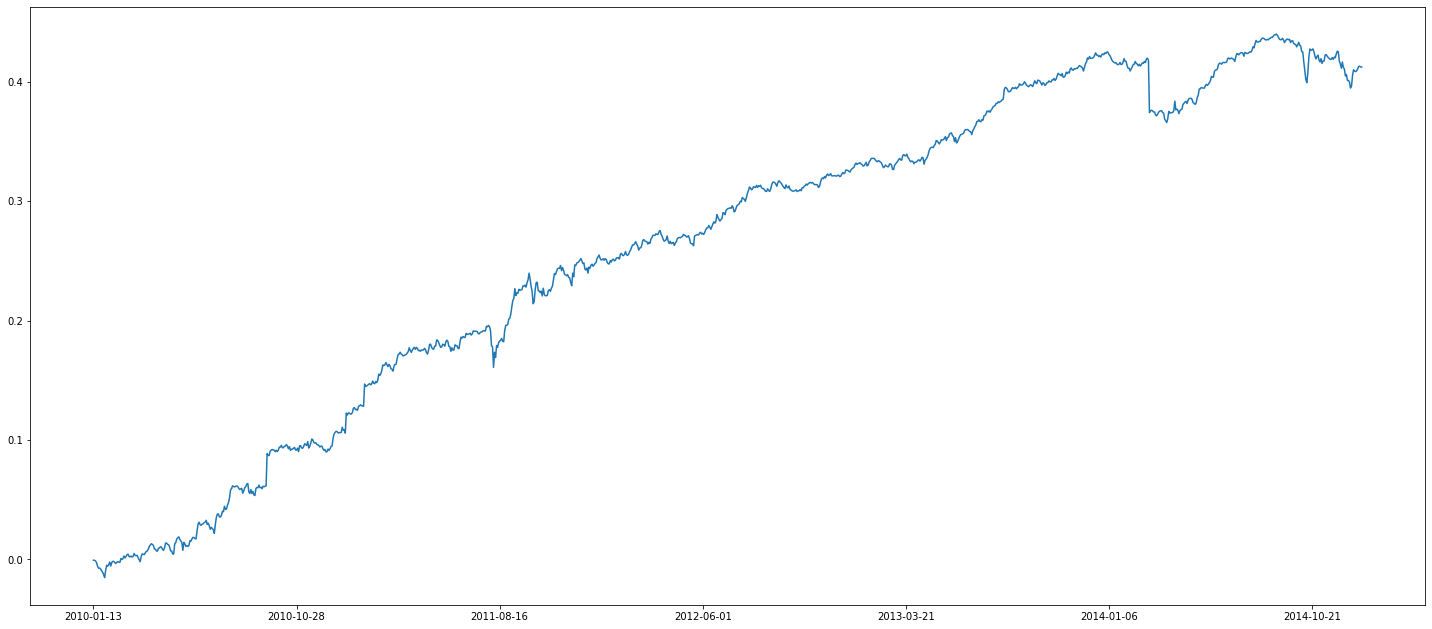

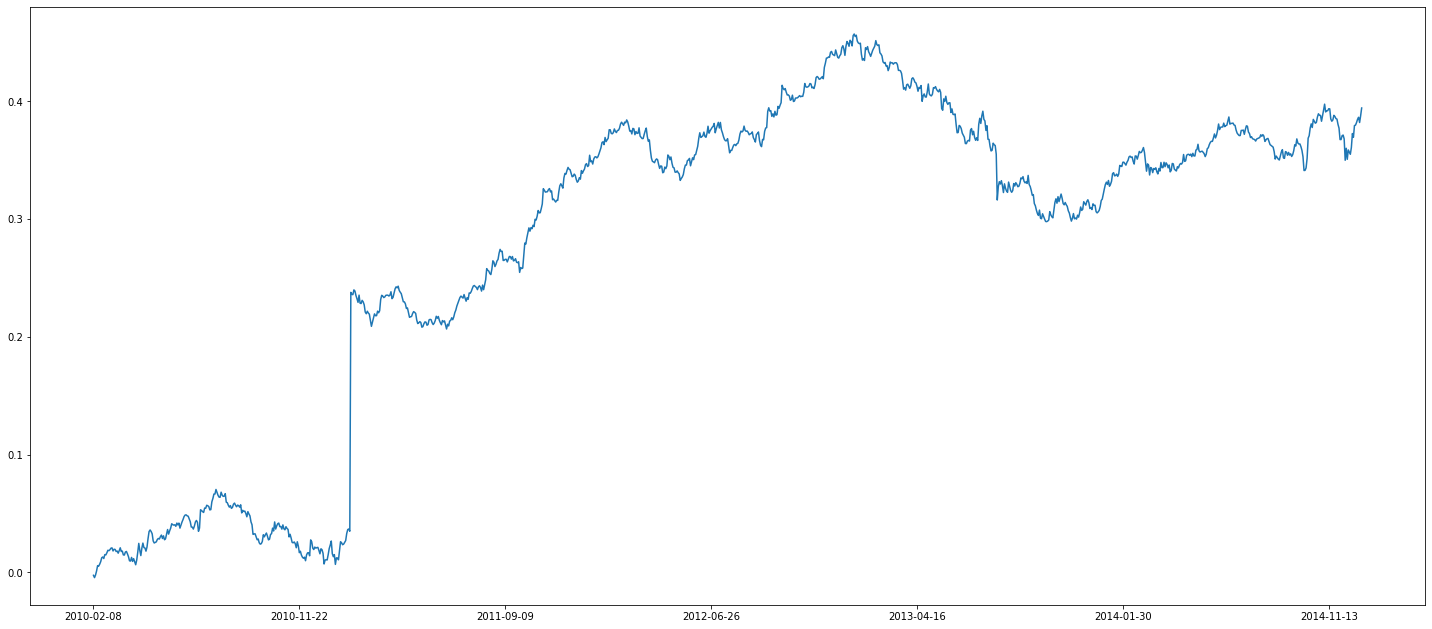

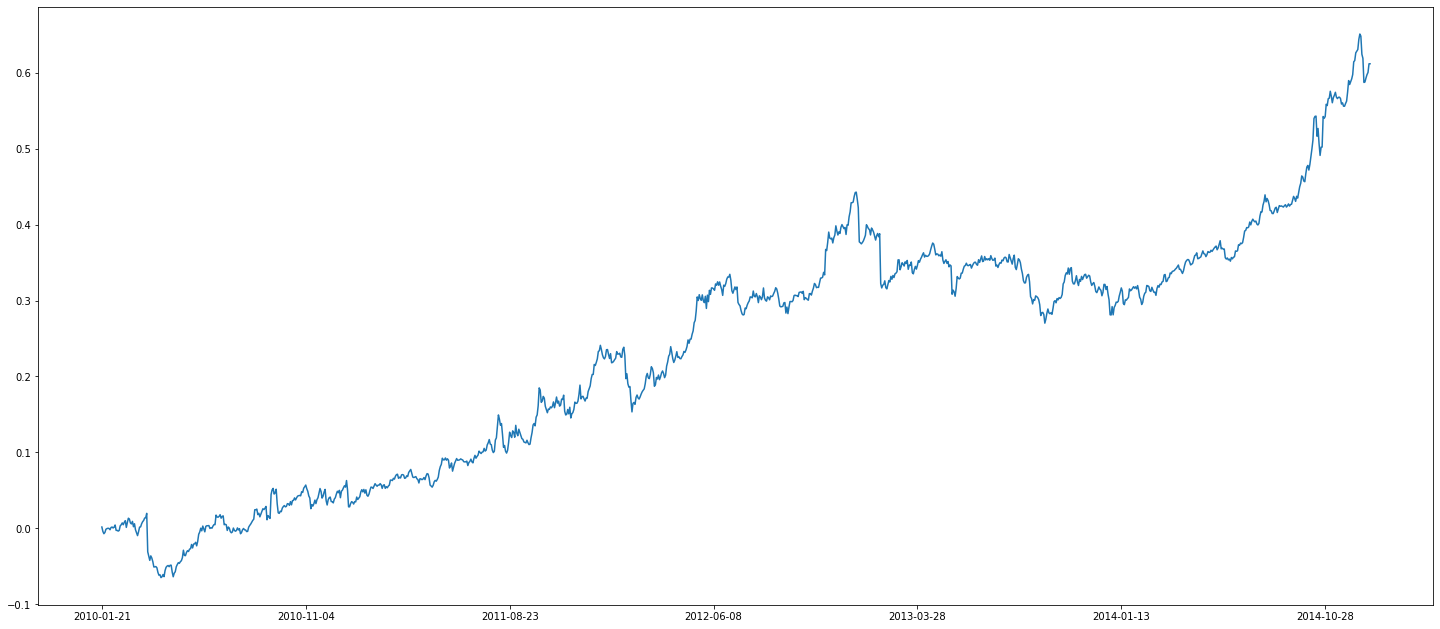

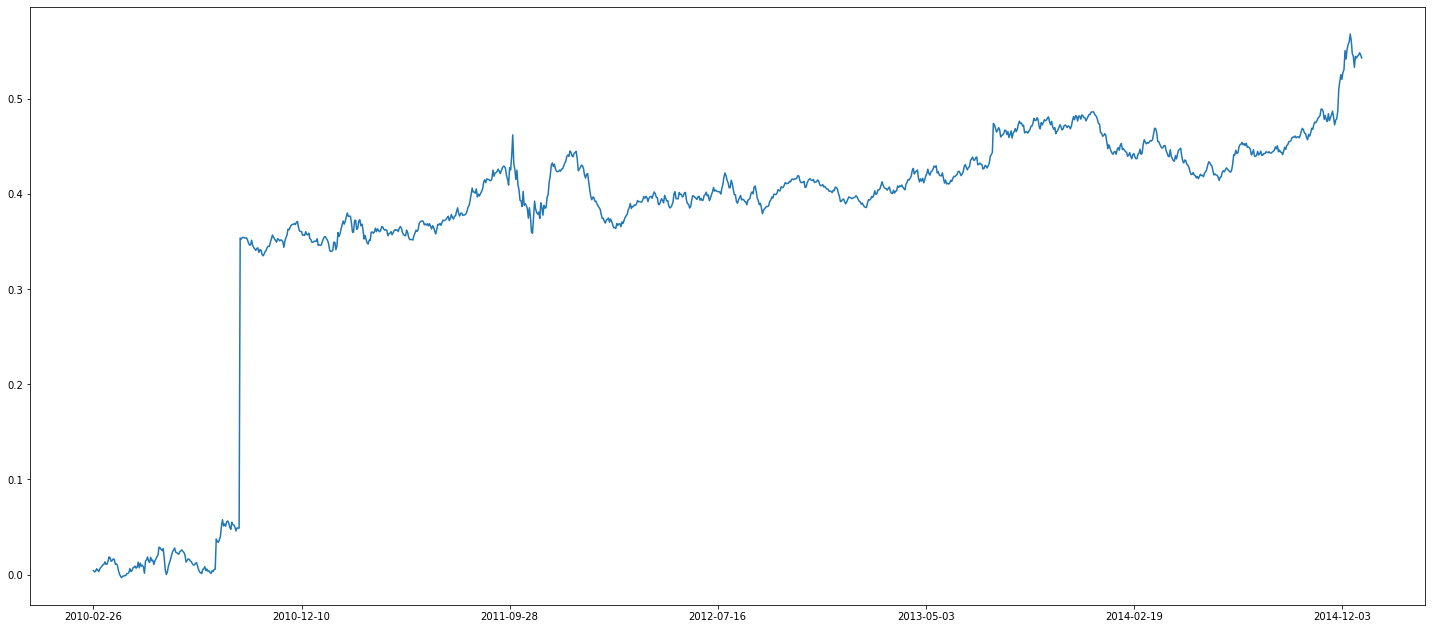

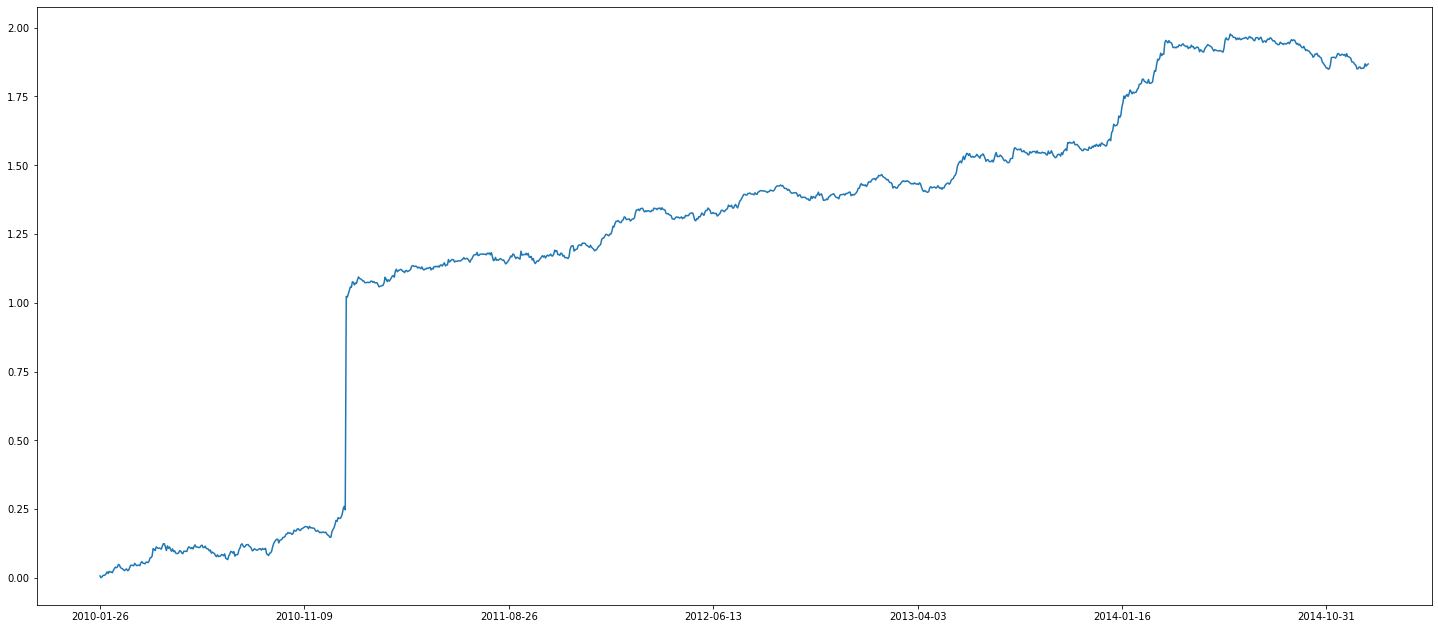

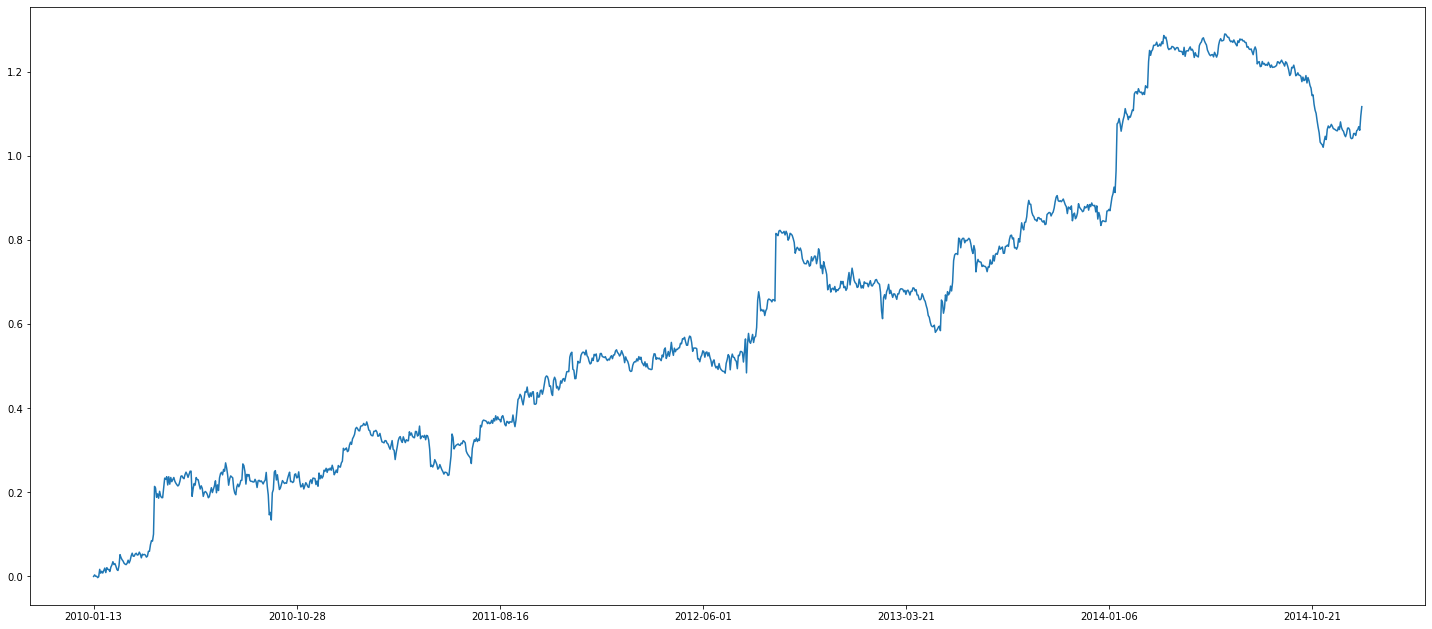

In [17]:
for i in alphas:
    cumprofit(i[1]).plot(figsize=(25,11))
    plt.show()